<center><img src='../../img/ai4eo_logos.jpg' alt='Logos AI4EO MOOC' width='80%'></img></center>

<hr>

<br>

<a href="https://www.futurelearn.com/courses/artificial-intelligence-for-earth-monitoring/1/steps/1280519"><< Back to FutureLearn</a><br>

# Using Machine Learning for water type classification: a naive bayesian approach

<i>by Ben Loveday (Innoflair), Hayley Evers-King (EUMETSAT) and Lauren Biermann (Plymouth Marine Laboratory)</i>

<hr>

## Watch the video tutorial

In [1]:
from IPython.display import HTML
HTML('<div align="center"><iframe src="https://player.vimeo.com/video/631902414?h=1ef47555f3" width="640" height="360" frameborder="0" allow="autoplay; fullscreen; picture-in-picture" allowfullscreen align="middle"></iframe></div>')     

<hr>

## Introduction



*Why are we doing this?*

Coastal oceans are where society meets the sea. Coastal ocean waters provide a large proportion of the worlds food through aquaculture and fisheries, and are the site of many socially and economically important activities including tourism and recreation, ports and shipping, and renewable energy generation. Management of these regions is therefore vitally important to sustainable development. 

Coastal ocean water quality influences suitability of areas for fishing, aquaculture and tourism, and can be negatively impacted by various industries operating in the marine domain. Data is needed to monitor the impact of different industries, conduct marine spatial planning, and for compliance with policy such as the European water and marine strategy framework directives. Satellite ocean colour data can provide information on coastal water quality at temporal and spatial scales suitable for these activities. However, translating the measurements the satellite makes (essentially of light of different colours) into properties of interest (water transparency, biological activity, and sediment concentrations) is challenging, particularly in coastal regions.


<br>

*What will this workflow show you?* 

This workflow guides you through classification of ocean colour data for the derivation of water quality relevant information. It will guide you through the process of training of a `naive bayesian classifier` on [Sentinel-3 OLCI](https://www.eumetsat.int/ocean-colour-services) data in order to identify complex waters.

## Machine-Learning Algorithms

In this workflow you will learn about applying machine-learning related methods to ocean colour data.

This example uses a [Naive Bayes Classifier, from the SciKit learn toolbox](https://scikit-learn.org/stable/modules/naive_bayes.html). This is a relatively simple method based on Bayes Theorem, that works fast and requires relatively small amounts of training data. The method has a key assumption that the features it classifies are independent.

## Data

This workflow uses the following data:
* An [OLCI full resolution Level-1](https://www-cdn.eumetsat.int/files/2021-03/Sentinel-3%20OLCI%20Marine%20User%20Handbook.pdf) scene for the North Sea 16.04.2021
* An [OLCI full resolution Level-2](https://www-cdn.eumetsat.int/files/2021-03/Sentinel-3%20OLCI%20Marine%20User%20Handbook.pdf) scene for the North Sea 16.04.2021
* The spectral output of a radiative transfer model to simulate remote sensing reflectances from a range of in water properties (adapted from [Evers-King et al. (2014)](https://www.osapublishing.org/oe/fulltext.cfm?uri=oe-22-10-11536&id=284439))

The workflow in this notebook involves the process of training your own naive bayesian classifier, and application to a standard OLCI Level-2 product. No pre-training is required.

## Further resources

* [OLCI Marine User Handbook](https://www.eumetsat.int/media/45743)
* [Mobley et al., 2003 - Optical Modelling of Ocean Waters: Is the Case 1 Case 2 classification still useful?](http://misclab.umeoce.maine.edu/documents/ocean_17.2_mobley_lo.pdf)
* [Naive Bayes classifier](https://towardsdatascience.com/naive-bayes-classifier-81d512f50a7c)
* [Application to Naive Bayes classifiers to marine debris](https://www.nature.com/articles/s41598-020-62298-z)
* [Sensitivity in reflectance attributed to phytoplankton cell size: forward and inverse modelling approaches](https://www.osapublishing.org/oe/fulltext.cfm?uri=oe-22-10-11536&id=284439)

<hr>

## Notebook outline
* [1 - Introduction to ocean colour and OLCI marine data](#OLCI_intro)
* [2 - Interpreting OLCI spectra](#OLCI_spectra)
* [3 - Example: Classifying spectra with a Naive Bayesian Classifier](#example1_NBC)
* [4 - Conclusions](#conclusions)

<hr>

#### Import libraries

In [2]:
import os # a library that gives us access to various command line tools to support pathing
import cartopy.crs as ccrs # a library that gives us access to cartopy's mapping capability
import cartopy.feature as cfeature # a library that extends cartopy to include features such as land masks

import fnmatch # a library to allow us to discover files in our filesystem

import matplotlib # the basic python plotting library
from matplotlib import gridspec # a library that gives us better control over plot spacing
import matplotlib.pyplot as plt # the basic Python plotting library figure tools

import xarray as xr # a library to extend array management and add labelling
import numpy as np # Python's array manipulation library 

from sklearn.naive_bayes import GaussianNB # the library for constructing naive bayesian classifiers 

import warnings # a library to manage warnings

warnings.filterwarnings('ignore')

#### Defined functions

In [3]:
import ocean_support_functions_4F as osf # an accompanying library of bespoke functions to support this notebook

<hr>

## 1. Introduction to ocean colour and OLCI marine data <a id='OLCI_intro'></a>

The ocean colour signal is made up of light reflected by the different components in the ocean waters.  We can get a rough idea of what is in ocean waters just by looking at the colour with our own eyes - we associate blue with water, brown with sediments, and green with plant-life (in the ocean, this green comes from plant-like organisms called phytoplankton). However, if we want to know how much sediment or phytoplankton are in a particular patch of ocean, this is not something we can easily estimate visually. In coastal waters, this is even more complicated because there is often a mix of different things in the water, and situations can change rapidly in space and time thanks to the dynamic nature of the coastal oceans. Coastal currents, algal blooms, increased river flow from flooding, storms, pollution, all make the colour of the coastal ocean highly variable.

The Ocean and Land Colour Instruments (OLCI) aboard the Sentinel-3 satellites provides near daily coverage, at 300 m resolution, using a high number of narrow spectral bands with suitable signal to noise ratio for the oceans. All of these characteristics help towards getting the most accurate data about the colour of the coastal ocean but we still have a challenge to turn the signal in to the information that decision makers need, and this is where machine learning can help.

Ocean colour data from OLCI is available from EUMETSAT at two levels - Level-1 and Level-2. Level-1 data is the top-of-atmosphere product where the signal has not yet been corrected for the influence of the atmosphere. At level-2 atmospheric correction has been performed so that you have the signal from the water, as well as some geophysical properties that have been derived from it. OLCI data products include the 'colour' data which is properly referred to as measurements of radiance or reflectance at the different wavelengths of light that the OLCI instrument measures at. OLCI measures at 21 wavelengths and has 21 spectral bands, although not all of these are used for parameter retrieval, some are solely used for atmospheric correction. 

You can find information about OLCI data formats and processing in the [OLCI marine user handbook](https://www.eumetsat.int/media/45743). You will also find OLCI data integrated in to other products such as those available from the Copernicus services. We are choosing to use the level-1 and 2 data here as these products typically offer the maximum detail (in terms of spectral and spatial resolution) and greatest flexibility for developing our own processing. This is helpful when looking at ocean colour applications in complex waters.

Let us take a look at this data to understand more about what it can tell us about water quality.

### A small bit of preparation; setting some parameters

To start with, we are going to set some parameters for running our notebook in order to control image management and plotting. You do not need to alter anything here, but if you find that you are having memory problems on your local system you can increase the grid_factor parameter and/or reduce the size of your subset. You can also set these parameters to false if you want to try running with a full image!

In [22]:
# image reduction settings: resample the image every grid_factor points
run_reduce_image = True
grid_factor = 5

# subset image: cut a relevant section out of an image. subset_extents [lon1,lon2,lat1,lat2] describes the section.
run_subset_image = True
subset_extents = [-2.0, 12.0, 51.75, 59.25]

# image plotting settings: e.g. fontsize (fsz) and dots-per-inch dpi
fsz = 10
plt.rc('font', size=fsz)
dpi = 150

# get our land mask from NaturalEarth
land_poly = cfeature.NaturalEarthFeature('physical', 'land', '10m',
                                    edgecolor='k', facecolor=cfeature.COLORS['land'])

Below we define three spatial boxes, over which we will compare OLCI spectra. We also set the maximum band value (in nm) for the spectral data you will use to train the model in this workflow.

In [5]:
# spectral_box_extents: Selects are area (or point) to extract spectra from
spectral_box_extents = [[10.0, 10.5, 57.75, 58.25], [3.5, 4.0, 53.25, 53.75],[7.75,8.25,54.25,54.75]]
spectral_plot_cols = ['#00FFFF','#FF6103', '#8A2BE2']

# maximum band to match OLCI with training data set
band_max = 760

<br>

### Loading the example images

You will begin by setting a few parameters, such as `DATA_PATHS` to that point where you can find the example OLCI data. 

In [6]:
# set data paths and files names
DATA_PATHS = [os.path.join(os.getcwd(),'Support_data',
              'S3A_OL_1_EFR____20210416T095514_20210416T095814_20210417T142009_0179_070_350_1980_MAR_O_NT_002.SEN3'),
              os.path.join(os.getcwd(),'Support_data',
              'S3A_OL_2_WFR____20210416T095514_20210416T095814_20210417T203718_0179_070_350_1980_MAR_O_NT_003.SEN3')]

<br>

To get an overall picture of how this data looks for this place and time, you can create what is known as an `RGB` image. The 'RGB' stands for Red, Green, Blue, because, to create these type of images, you select data from red, green, and blue wavebands. In the next section of code, you read in the relevant coordinate data (latitude and longitude) and the data from the radiance (level-1) and reflectance (level-2) bands. Lastly you create combinations of red, green, and blue bands, here using a recipe called ['tristimulus'](https://www.britannica.com/science/tristimulus-system).

In [7]:
# read channels
lon, lat, red_L1, green_L1, blue_L1, rlon, rlat = osf.get_OLCI_RGB(DATA_PATHS[0],\
                                         run_reduce_image=True,\
                                         run_subset_image=run_subset_image,\
                                         subset_extents=subset_extents,\
                                         return_orig_coords=True)

lon, lat, red_L2, green_L2, blue_L2, rlon, rlat = osf.get_OLCI_RGB(DATA_PATHS[1],\
                                         run_reduce_image=True,\
                                         run_subset_image=run_subset_image,\
                                         subset_extents=subset_extents,\
                                         return_orig_coords=True)

<br>

In this next section you use a few functions to make it easier to plot the data in the interactive environment of the Jupyter Notebook. If you wish to understand this process in more detail, you can see the functions in the accompanying file - [ocean_support_functions_4F.py](./ocean_support_functions_4F.py), which you will find in the same folder as this notebook.

In [8]:
image_array_L1, colorTuple_L1, lon, lat = osf.process_image(lon, lat, red_L1, green_L1, blue_L1,\
                                          run_truncate_image=True,\
                                          run_histogram_image=True)

image_array_L2, colorTuple_L2, lon, lat = osf.process_image(lon, lat, red_L2, green_L2, blue_L2,\
                                          run_truncate_image=True,\
                                          run_histogram_image=True)

<br>

...and finally you plot both images, using functions from the cartopy library.

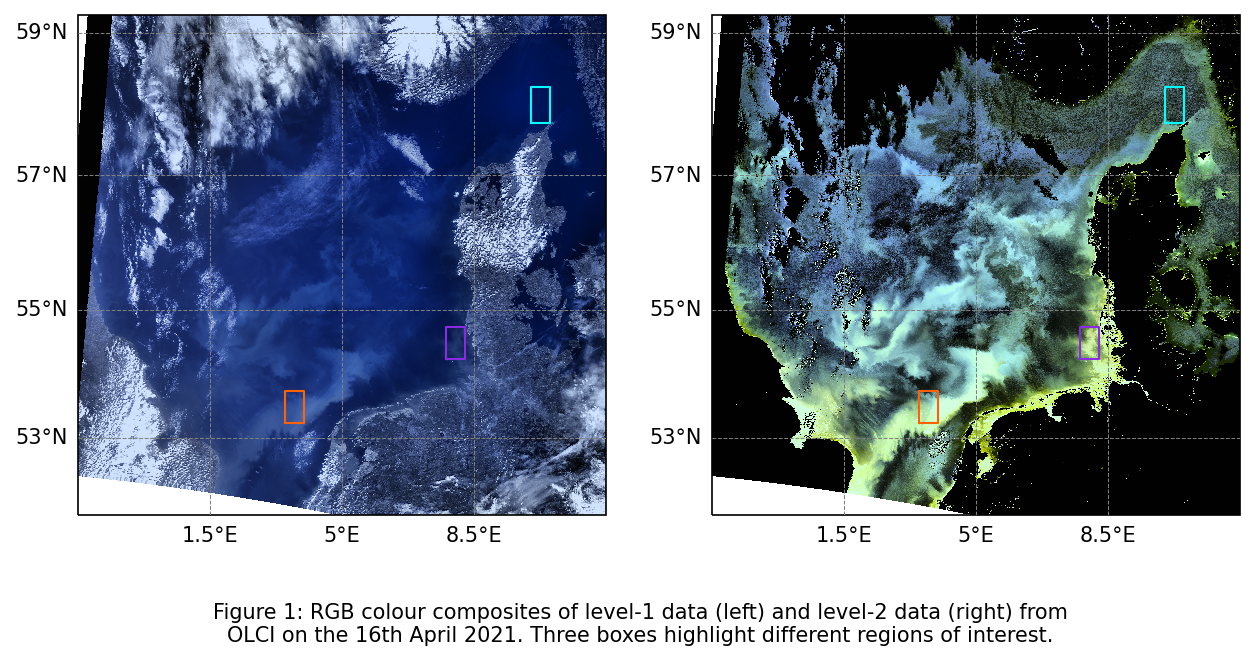

In [9]:
# intitialise a figure
fig1 = plt.figure(figsize=(10, 5), dpi=dpi)
gs = gridspec.GridSpec(1, 2)

# make an axis and plot
m = plt.subplot(gs[0,0], projection=ccrs.Mercator())
p1 = osf.plot_OLCI_scene(m, lon, lat, lon, run_subset_image=True, RGB_plot=True, \
                    subset_extents=subset_extents, colorTuple=colorTuple_L1, fsz=fsz)
# embellish with spectral boxes
osf.add_boxes(m, spectral_plot_cols, spectral_box_extents)

# make an axis
m = plt.subplot(gs[0,1], projection=ccrs.Mercator())
p1 = osf.plot_OLCI_scene(m, lon, lat, lon, run_subset_image=True, RGB_plot=True, \
                    subset_extents=subset_extents, colorTuple=colorTuple_L2, fsz=fsz)
# embellish with spectral boxes
osf.add_boxes(m, spectral_plot_cols, spectral_box_extents)

# add caption
fig1.text(0.5, 0.0, r'Figure 1: RGB colour composites of level-1 data (left) and level-2 data (right) from'+'\n'+ 
          'OLCI on the 16th April 2021. Three boxes highlight different regions of interest.',\
          ha='center', fontsize=10)
plt.show()

<br>

You can use Figure 1 to compare the Level-1 and Level-2 data, and to start to understand how different water types manifest in the ocean colour signal. 

The first thing you can note is that the figure on the left, is much bluer than the one on the right. This is predominantly the effect of the atmosphere, which is present in the Level-1 data (left) but not in the Level-2 (right). The Level-2 RGB has also been enhanced by the choice of method you have used, so you are not seeing a true colour as such, but an enhanced RGB so that can be used to see some of the differences in the water colour more clearly. 

To focus on some of the differences, we have overlaid our 3 boxes to investigate a few regions of interest. The cyan box contains waters that show up as dark blue, the orange box a lighter blue-green colour, and the purple box more green-brown in colour. You can infer from this that the patch of ocean in the cyan box has probably got relatively low concentrations of sediments or phytoplankton, whilst the other two boxes are likely more mixed, with potentially higher concentrations of phytoplankton and/or sediments. Just looking at the images like this it is hard to say exactly what is going on, particularly in the latter two boxes. As mentioned before, a benefit of the satellite ocean colour data is that we don't have to look at it as an integrated single colour as our eyes see, we can look more at the detail. Next, let's look at the colour spectra associated with these regions of interest...

<br>

## 2. Interpreting OLCI spectra<a id='OLCI_spectra'></a>

OLCI has 21 spectral `bands` - these are the wavelengths within the electromagnetic spectrum where the instrument senses the reflected light leaving the Earths surfaces. Some of these are useful for determining atmospheric properties, but most give us information on the ocean surface. In this section, we'll extract the ocean colour spectra from the OLCI data, associated with the three regions of interest we define above. 

First we get the metadata information we need to extract the data at the different bands.

In [10]:
# get wavelengths from xml file
bands = [] ; wavelengths = []; bandwidths = []    
xml_file = os.path.join(DATA_PATHS[1],'xfdumanifest.xml')
with open(xml_file, 'r') as input_file:
    for line in input_file:
        if "<sentinel3:band name=" in line:
            bands.append(line.replace('<sentinel3:band name="',"").replace('">','').replace(' ','').replace('\n',''))
        if "<sentinel3:centralWavelength>" in line:
            wavelengths.append(float(line.replace('<sentinel3:centralWavelength>','')\
                                     .replace('</sentinel3:centralWavelength>','')))
        if "<sentinel3:bandwidth>" in line:
            bandwidths.append(float(line.replace('<sentinel3:bandwidth>','').replace('</sentinel3:bandwidth>',''))/2)

<br>

Now we will read in the reflectances for our box for all the bands. Here we read in all the spectra over each of our boxes, for every wavelength and make an average spectra for each box.

In [11]:
# -get the files by band name-------------------------------------------------------------
nc_files=[]
for root, _, filenames in os.walk(DATA_PATHS[1]):
    for filename in fnmatch.filter(filenames, '*reflectance*.nc'):
        nc_files.append(os.path.join(root, filename))

# get the reflectances for our box or point
all_reflectances = []; all_reflectance_errors = []; all_variability = []; all_uppers = []; all_lowers = []

for spectral_box_extent in spectral_box_extents:
    print('Processing box...')
    I1, I2, J1, J2 = osf.get_coords(rlon, spectral_box_extent[0], spectral_box_extent[1],\
                                    rlat, spectral_box_extent[2], spectral_box_extent[3], False)

    reflectances = []; reflectance_errors = []; variability = []
    for nc_file in sorted(nc_files):
        varname  = os.path.basename(nc_file).split('.')[0]
        nc_fid   = xr.open_dataset(nc_file)
        reflectances.append(np.nanmean(nc_fid.variables[varname][I1:I2,J1:J2]))
        variability.append(np.nanstd(nc_fid.variables[varname][I1:I2,J1:J2]))
        reflectance_errors.append(np.nanmean(nc_fid.variables[varname+'_err'][I1:I2,J1:J2]))
        nc_fid.close()
    all_uppers.append([x + y for x, y in zip(reflectances, variability)])
    all_lowers.append([x - y for x, y in zip(reflectances, variability)])
    all_reflectances.append(reflectances)
    all_reflectance_errors.append(reflectance_errors)
    all_variability.append(variability)

Processing box...
Processing box...
Processing box...


<br>

Now we plot these spectra.

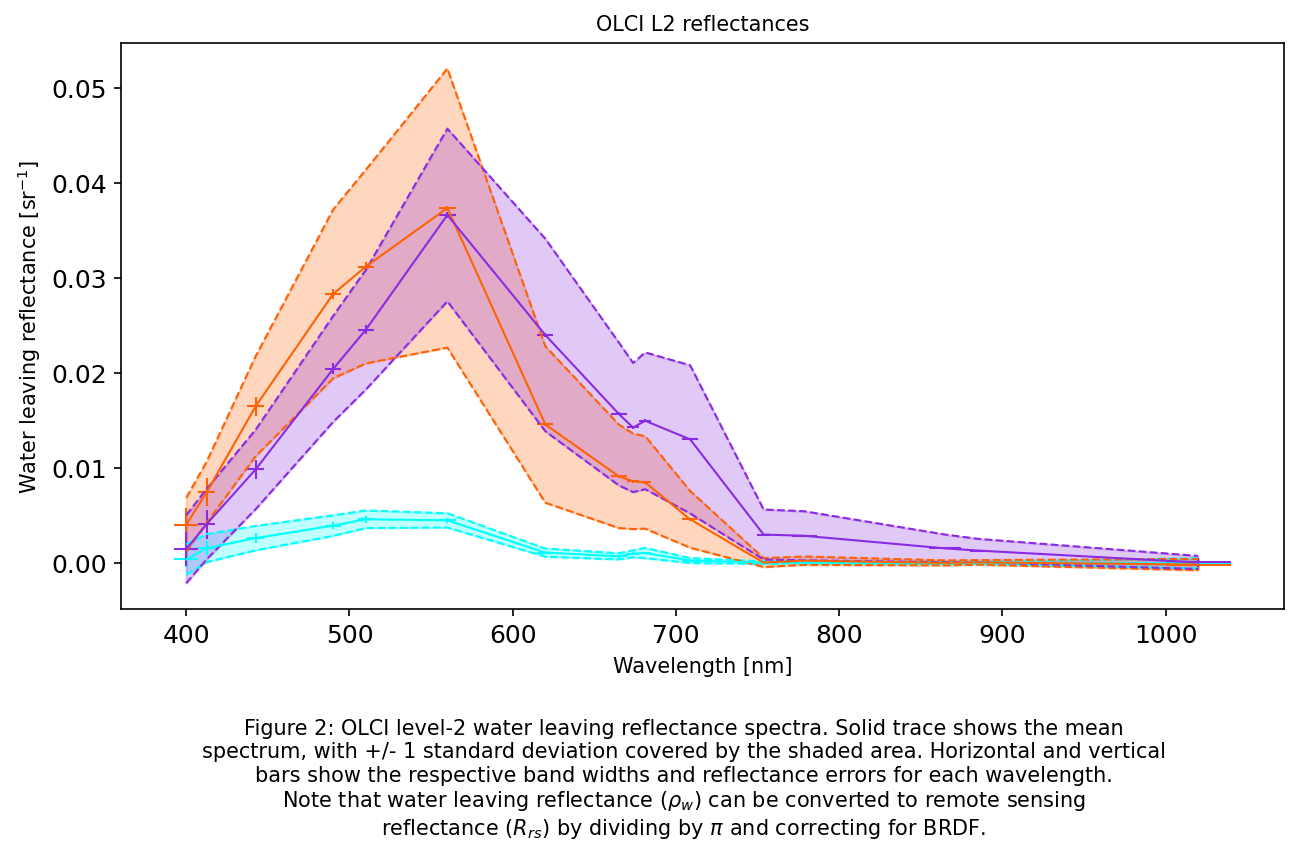

In [12]:
# initialise a figure
fig1 = plt.figure(figsize=(10, 5), dpi=dpi)

# gather our spectra and plot
for reflectances, reflectance_errors, uppers, lowers, spectral_plot_col in \
  zip(all_reflectances, all_reflectance_errors, all_uppers, all_lowers, spectral_plot_cols):
    plt.errorbar(wavelengths, reflectances, xerr=bandwidths, yerr=reflectance_errors,
      color=spectral_plot_col, linewidth=1.0)
    plt.plot(wavelengths, uppers, color=spectral_plot_col, linestyle='--',linewidth=1.0)
    plt.plot(wavelengths, lowers, color=spectral_plot_col, linestyle='--',linewidth=1.0)
    plt.fill_between(wavelengths,uppers,lowers,color=spectral_plot_col,alpha=0.25)
    
plt.xlabel('Wavelength [nm]', fontsize=fsz)
plt.ylabel('Water leaving reflectance [sr$^{-1}$]', fontsize=fsz)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
plt.title('OLCI L2 reflectances', fontsize=fsz);

# add caption
fig1.text(0.5, -0.175, r'Figure 2: OLCI level-2 water leaving reflectance spectra. Solid trace shows the mean'+'\n'+ \
          r'spectrum, with +/- 1 standard deviation covered by the shaded area. Horizontal and vertical'+ '\n' + \
          r'bars show the respective band widths and reflectance errors for each wavelength.' +'\n' + \
          r'Note that water leaving reflectance ($\rho_w$) can be converted to remote sensing' +'\n' + \
          r'reflectance ($R_{rs}$) by dividing by $\pi$ and correcting for BRDF.', ha='center', fontsize=fsz)
plt.show()

<br>

### Challenges interpreting spectra

In Figure 2 you can see the average (and range of) reflectance spectra for each of the regions of interest. We can make a few simple observations which will tell us a bit more about what's likely to be in the water at each of these locations. 

Firstly, the spectra from the orange and purple boxes are much higher in general. This tells us that there is more reflection from the water in these areas. Increased reflection typically means that we have a great proportion of components that scatter in the water - this is often sediments, but can also be from certain types of phytoplankton such as coccolithophores, or species with very small cells or complex internal structures. 

Secondly we can note that there is substantial overlap in the ranges of reflectance between the regions in the orange and purple boxes. This implies that, while there may be some differences, it might be difficult to distinguish between these regions and extract information about the water properties.

A third thing we can observe is a small feature in the 665-710 nm range. This feature is associated with chlorophyll-a absorption and fluorescence, and this indicates that there is at least some phytoplankton activity in all the regions. 

Interpreting what these spectra mean can be challenging, but is the basis of all quantitative retrievals of ocean parameters from this data. It is very difficult to fully interpret a spectra by eye, and would be very laborious to do for the high number of pixels that make up an image. Machine Learning can help us to improve how we classify water types, and how we choose methods to apply to calculate properties we are interested in to estimate concentrations of different constituents like phytoplankton and sediments. In the next section, we'll look at how we can train a simple model to identify two different water types. 

<br>

## 3. Example: Classifying spectra with a Naive Bayesian Classifier<a id='example1_NBC'></a>

An essential part of any Machine Learning workflow, is developing a training data set for the model you wish to use. The choice of training data can be a key determinant of the success of the model when it is applied. 

From an ocean colour perspective, this means that you need to have training data that represents the variety of different optical properties found in ocean waters. In many remote sensing applications, training data is gathered by visual inspection of images to identify features that we are interested in, but in the ocean this is not really possible. As shown in this workflow so far, it is not necessarily easy or reliable for us to classify ocean colour images with our own eyes, and much more information is available from spectrally resolved data that can be used to inform the retrieval of geophysical parameters. As a result of this, applying Machine Learning to ocean colour data often requires the use of in situ or modelled data sets that characterise ocean colour spectra in relation to ocean properties of interest such as concentrations of chlorophyll-a, sediments, or coloured dissolved organic matter, all of which are useful for ocean water quality management.

In this section you will work through a simplified example with a training data set to see if you can classify pixels within ocean colour images into two broad types, based on whether they have high levels of sediments and dissolved organic matter (as is common in coastal regions) or not. 

### Training data 

The training data we will work with here comes from a combination of models that allows for simulation of reflectance spectra as measured by satellite instruments like OLCI. The models used in this instance include an inherent optical property model, which determines the absorption and scattering properties of the water based on a choice of parameters; and a radiative transfer model, which takes these absorption and scattering properties and calculates the reflectance (ocean colour) signal. For more information on the models used to generate this data set, see Evers-King et al., 2014. 

For this example we have chosen this training data set to see if we can classify an image into two broad water types linked to what we observed above. The first water type, which we shall refer to as case-1, does not have lots of sediments and coloured dissolved organic matter in. These are types of water that might exist in the open ocean, or in coastal areas without strong riverine inputs. The second type, which we will call case-2, does have a lot of these non-phytoplankton constituents. 
Please note that this data set is for demonstration purposes only, and is not appropriate for wider scientific use in the form provided here. 

For any Machine Learning application using ocean colour data you could create a training data set using your own models, depending on what constituents you wanted to investigate, and there are many tools and literature examples that can support this. You could also gather a data set from coincident in situ data - this can be more representative of reality, because all models come with assumptions, however it can be hard to gather enough data points to be representative of the real variability of the parameters of interest in the ocean. See the next section for an example which uses a very extensive in situ and model data set in its training approach. 

First, let us open the training data set for this example workflow. The cells below set our data files and then open and read in our training data.

In [13]:
training_data = os.path.join(os.getcwd(),'Support_data','Modelled_spectral_reflectance_data.nc')
eco = xr.open_dataset(training_data)
ECO_wavs = eco.wavelength # these are our wavelengths
ECO_Rrs = eco.RRS_MOD # these are our modelled remote sensing reflectances
ECO_LNLG = eco.LNLG # this is our flag our low non-algal, now CDOM waters
ECO_HNHG = eco.HNHG # this is our flag for high non-algal, high CDOM waters >> e.g. complex waters!
eco.close()

<br>

Now, let us plot the modelled ocean colour spectra that make up the training data set...

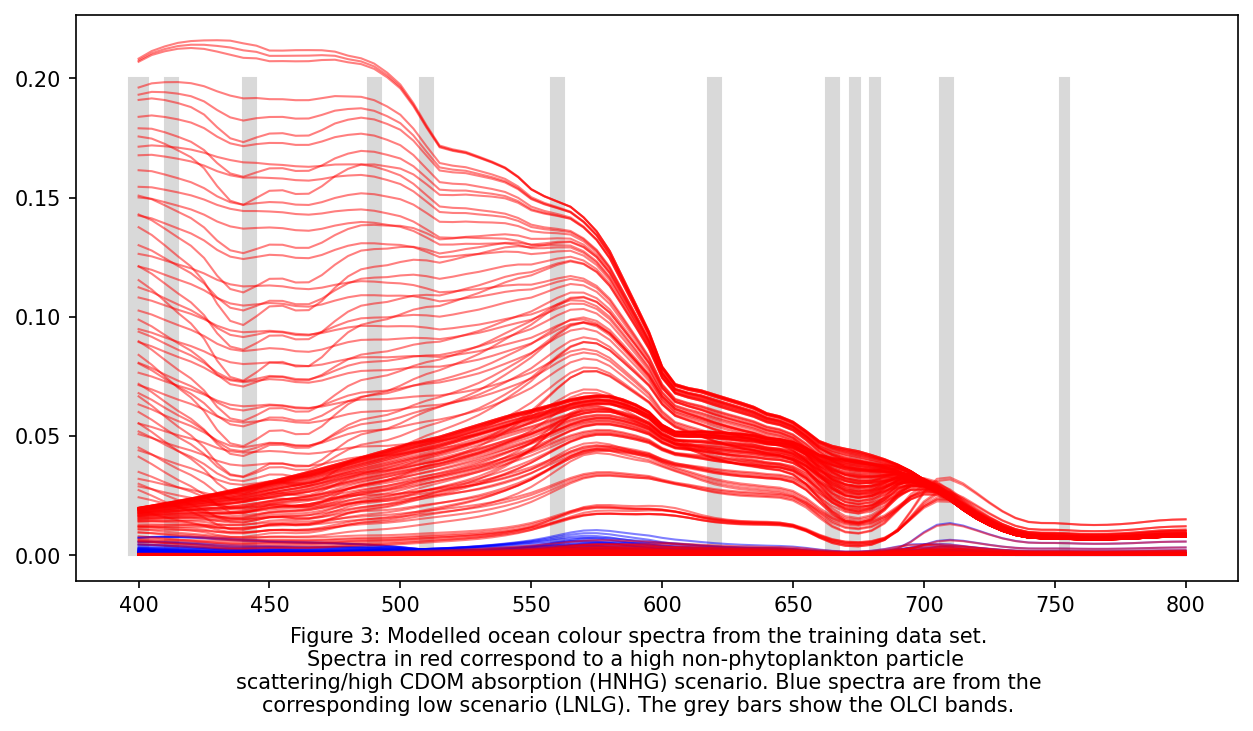

In [14]:
# initialise a figure
fig1 = plt.figure(figsize=(10, 5), dpi=dpi)

# gather our spectra and plot
for ii in range(0,np.shape(ECO_Rrs)[1]):
    if ECO_LNLG[ii] == 1:
        plt.plot(ECO_wavs, ECO_Rrs[:,ii], 'b', linewidth=1.0, alpha=0.5, zorder=1)
    else:
        plt.plot(ECO_wavs, ECO_Rrs[:,ii], 'r', linewidth=1.0, alpha=0.5, zorder=2)
        
for wv, bd in zip(wavelengths, bandwidths):
    if wv < band_max:
        plt.fill([wv-bd/2, wv-bd/2, wv+bd/2,wv+bd/2], [0,0.2,0.2,0],color='0.85', zorder=0)

# add caption
fig1.text(.5, -0.05, r'Figure 3: Modelled ocean colour spectra from the training data set.'+'\n'\
          +'Spectra in red correspond to a high non-phytoplankton particle '+'\n'\
          +'scattering/high CDOM absorption (HNHG) scenario. Blue spectra are from the'+'\n'\
          +'corresponding low scenario (LNLG). The grey bars show the OLCI bands.', ha='center', fontsize=10)

plt.show()

<br>

How do we interpret these spectra? Well, based on what we learned before we can see that we have some spectra with generally higher magnitude (most of the red spectra) and others that are generally lower (in blue). This corresponds with what we know about highly scattering waters and waters with lower scattering and/or high absorption respectively. And indeed, this corresponds with the parameters that were used to generate the modelled spectra where blue corresponds to the case-1 scenario and red, the case-2 scenario. The variability that you see in the two cases, comes from model scenarios that were run to include changes in the phytoplankton present in the water (represented by chlorophyll-a concentrations and the effective size of the cells in the assemblage). Whilst not a fully comprehensive representation of all possible combinations of chlorophyll-a concentration, phytoplankton size, scattering from sediments, and absorption from dissolved organic matter, the training data here should be representative enough to roughly classify images in to the two types described, based on the reflectance spectra of each pixel. 

<br>

### Training the model

To train the model, you will first arrange the training dataset so it is in the same format as the OLCI bands that we ultimately want to apply the model to.

In [15]:
data_array = []
for wav in wavelengths:
    if wav < band_max:
        ii = np.argmin(abs(ECO_wavs.values-wav))
        data_array.append(ECO_Rrs[ii,:])
data_array = np.array(data_array).transpose()

<br>

In the next section of code, you will split the data set to keep some data for validation. This is common in Machine Learning as it allows you to more independently verify the performance of your model. 

In [16]:
# split into testing and training arrays: put one third in the test data and keeping 2/3 for training
test_indices = np.zeros(ECO_HNHG.size, dtype=bool)
test_indices[::3] = True

<br>

...then you provide the training data to the `naive Bayes classification` function provided in the `scikit-learn` Python library to generate the model you want to use to classify the images. We feed the model the remote sensing reflectance values and our complex waters flag.

In [17]:
# Train model
GNB = GaussianNB() 
class_model = GNB.fit(data_array[test_indices==False,:], ECO_HNHG[test_indices==False])

<br>

Now lets check how well our test data fits our training data.

In [18]:
# Rough idea of how well the model output fits the training data
score = class_model.score(data_array[test_indices==True,:], ECO_HNHG[test_indices==True])
print("Naive Bayes Classification Fit: {:.02}".format(score))

Naive Bayes Classification Fit: 0.73


This is not a reasonable fit to our model, given the complexity of the input data. It is enough for us to continue.

<br>

### Apply the model to an image

Now that you have trained the model for classifying based on the spectra from the training data set, you can use the model to classify other spectra, such as those that exist at each pixel in an image from OLCI.

To start with, you open the image and read in a spatial subset as an array...

In [19]:
# Read in data and arrange for classifier input
num_channels = 12
image_array = np.zeros([num_channels,len(lon.ravel())])

if run_subset_image:
    i1, i2, j1, j2 = osf.subset_image(rlat, rlon, subset_extents)

for rad_channel_number in range(1, num_channels+1):
    print('Reading {}'.format(str(wavelengths[rad_channel_number-1])))
    rad_channel = 'Oa%s_%s' % (str(rad_channel_number).zfill(2),'reflectance')
    rad_file = os.path.join(DATA_PATHS[1], rad_channel + '.nc') 
    rad_fid = xr.open_dataset(rad_file)
    exec("this_channel = rad_fid.%s.data" % (rad_channel))
    rad_fid.close()
    this_channel = this_channel / np.pi
    if run_subset_image:
        this_channel = this_channel[i1:i2,j1:j2]
    if run_reduce_image:
        this_channel = osf.reduce_image(this_channel, grid_factor=grid_factor)
    image_array[rad_channel_number - 1,:] = this_channel.ravel()

image_array = np.array(image_array).transpose()

Reading 400.0
Reading 412.5
Reading 442.5
Reading 490.0
Reading 510.0
Reading 560.0
Reading 620.0
Reading 665.0
Reading 673.75
Reading 681.25
Reading 708.75
Reading 753.75


<br>

Next, you screen out any spectra we don't want to classify because they are missing data (i.e. are flagged and therefore not processed in the underlying image). Then you use the model you trained to classify the data from the image, and finally reshape it for plotting.

In [20]:
# screen out spectra with any bad data (e.g. NaN values)
output_array = np.zeros(np.shape(image_array)[0])*np.nan
ii = np.where(np.isfinite(np.sum(image_array, axis=1)))[0]
image_array_QC = image_array[ii,:]

# classify based on our model
outclasses = class_model.predict(image_array_QC)

# re-fit to original array size for plotting
output_array[ii] = outclasses
output_array = output_array.reshape(np.shape(lon))

<br>

The next section of code enables you to create a figure to show the output of applying the trained model to the OLCI image that you looked at earlier in this workflow.

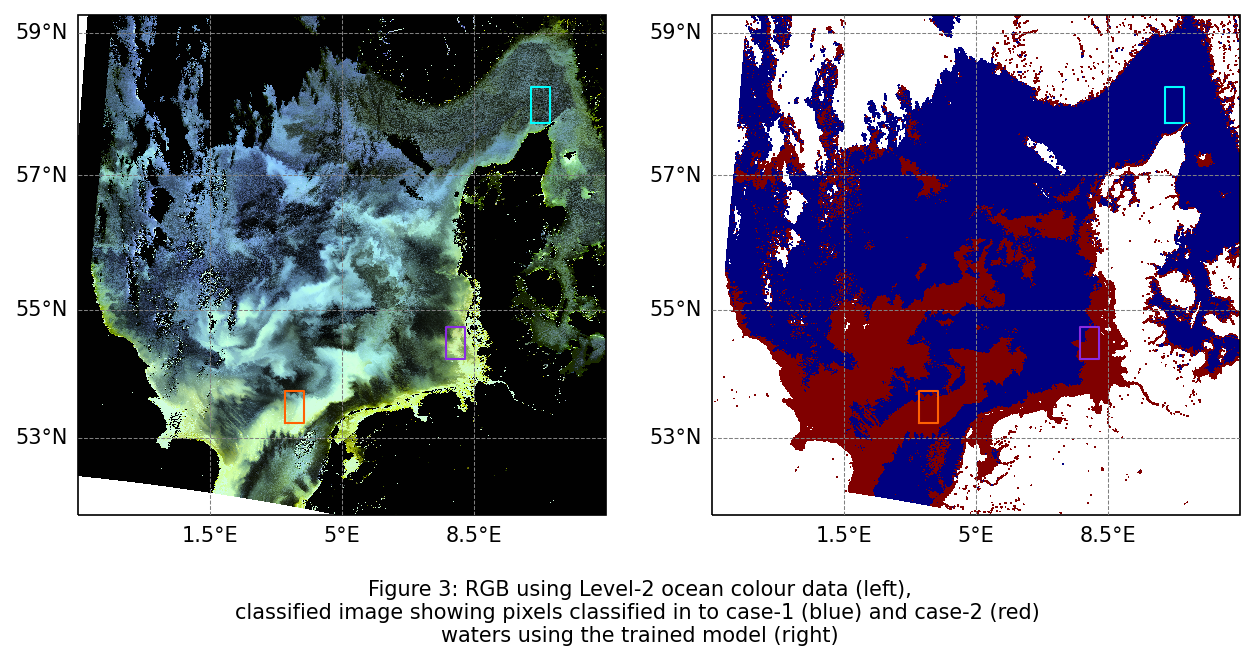

In [21]:
# intitialise a figure
fig1 = plt.figure(figsize=(10, 5), dpi=dpi)
gs = gridspec.GridSpec(1, 2)

# make an axis and plot
m = plt.subplot(gs[0,0], projection=ccrs.Mercator())
p1 = osf.plot_OLCI_scene(m, lon, lat, lon, run_subset_image=True, RGB_plot = True, \
                    subset_extents=subset_extents, colorTuple=colorTuple_L2, fsz=fsz)
# embellish with spectral boxes
osf.add_boxes(m, spectral_plot_cols, spectral_box_extents)

# make an axis and plot
m = plt.subplot(gs[0,1], projection=ccrs.Mercator())
p1 = osf.plot_OLCI_scene(m, lon, lat, output_array, run_subset_image=True, \
                    subset_extents=subset_extents,  cmap='jet', fsz=fsz)
# embellish with spectral boxes
osf.add_boxes(m, spectral_plot_cols, spectral_box_extents)

# add caption
fig1.text(0.5, 0.0, r'Figure 3: RGB using Level-2 ocean colour data (left),'+'\n'\
          +'classified image showing pixels classified in to case-1 (blue) and case-2 (red) '+'\n'\
          'waters using the trained model (right)', ha='center', fontsize=fsz)
plt.show()

<br>

The output image (Figure 3, right) shows whether each pixel in the image corresponds more to the case-1 or case-2 data groups in the training data set. The classifier clearly shows sediment dominated waters where we might expect them - i.e. near the coasts and where there are large river outflows. You can see that both the orange and purple boxes are classified as case-2 here. However the classification also highlights some areas that are more unexpected, such as in the middle of the North sea. In this instance it is likely that these areas include regions where coccolithophores are blooming. Coccolithophores are a type of phytoplankton that forms calcium carbonate "lith" structures to protect their bodies. Whilst they do contain chlorophyll-a, the liths scatter a lot of light, making waters with coccolithophores in highly reflective more akin to sediment dominated waters. This complexity, along with the fact that we cannot distinguish any differences between the case-2 pixels such as those in the orange and purple boxes, shows some of the limitations of our simple example.


### Is this useful? 

This sort of case 1/case 2 water typing, is a basic form of classification that has a long history in the science of ocean colour. You can read more about how this classification arose, and whether it is still useful in an article by [Mobley et al., 2003.](http://misclab.umeoce.maine.edu/documents/ocean_17.2_mobley_lo.pdf). 

A further issue we have with this example, is the assumption of independence between features that is inherent in the use of the Naive Bayes classifier. With the modelled data we have used, we have two distinct classes we have created with the model conditions, however the reality in the ocean is much more complicated. As Mobley et al. 2003, discuss, the case 1, case 2 definition doesn't really hold, as there are many 'in-between' water types. Further, ocean colour spectra that are similar, to such a degree that they may be indistinguishable, can occur with different combinations of constituents. This inherent ambiguity makes it difficult to apply simple classification and obtain accurate results [Defoin-Platel and Chami, 2007](https://agupubs.onlinelibrary.wiley.com/doi/pdf/10.1029/2006JC003847).

In short, simple classification can be useful conceptually and could be beneficial for applications that use broad metrics. However, for more accurate derivation of quantitative estimates of ocean parameters from ocean colour, we can do better, and indeed there are approaches that have been designed to do just that in the [next example](./4Fb_Using_ML_to_retrieve_water_quality_indicators_in_coastal_waters.ipynb).


<br>

## 4. Conclusions <a id='conclusions'></a>

For decision making about activities in our coastal oceans, data is often needed on water quality. Satellite ocean colour data can provide this information, but deriving the parameters needed from the signal can be complex because of the way that the optical properties of different constituents overlap. Machine Learning approaches can be developed using in situ and modelled data sets if they are representative of the wide variety of optical properties that occur in the oceans. Ultimately we can then retrieve estimates of parameters such as chlorophyll-a and sediment concentrations which allow us to monitor ocean impacts, plan marine activities, and meet international policy objectives for sustainable seas. 

For further examples of how Copernicus satellite data is used in water quality applications see [here](https://www.copernicus.eu/en/website-search?search_api_fulltext=water+quality).

<br>

<a href="https://www.futurelearn.com/courses/artificial-intelligence-for-earth-monitoring/1/steps/1171750"><< Back to FutureLearn</a><br>

<hr>

<img src='../../img/copernicus_logo.png' alt='Copernicus logo' align='left' width='20%'></img>

Course developed for [EUMETSAT](https://www.eumetsat.int/), [ECMWF](https://www.ecmwf.int/) and [Mercator Ocean International](https://www.mercator-ocean.fr/en/) in support of the [EU’s Copernicus Programme](https://www.copernicus.eu/en) and the [WEkEO platform](https://wekeo.eu/).
